<a href="https://colab.research.google.com/github/Ajeeetsingh/text-to-image-generator/blob/main/text_to_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text-to-Image Generator
A generative AI project using Stable Diffusion to create images from text prompts, deployed as a Streamlit web app on Google Colab with ngrok. Features dynamic prompt enhancement, user-controlled filters, and Google Drive storage.

Install Required Libraries

- diffusers: Hugging Face library for diffusion models like Stable Diffusion.
- transformers: Required for tokenizers and model components.
- torch: PyTorch, the backend for Stable Diffusion.
- streamlit: For building the web app UI (used later).

In [ ]:
!pip install diffusers transformers torch streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 109.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6

Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load stable diffusion model and generate image

- StableDiffusionPipeline: Hugging Face’s pipeline for Stable Diffusion.
- torch_dtype=torch.float16: Uses half-precision to reduce memory usage on GPU.
- pipe.to("cuda"): Moves the model to the GPU for faster inference.
- prompt: The text description for the image.
- num_inference_steps=50: Number of denoising steps (controls quality vs. speed).
- guidance_scale=7.5: Controls how closely the image follows the prompt.
- image.show(): Displays the image in Colab

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

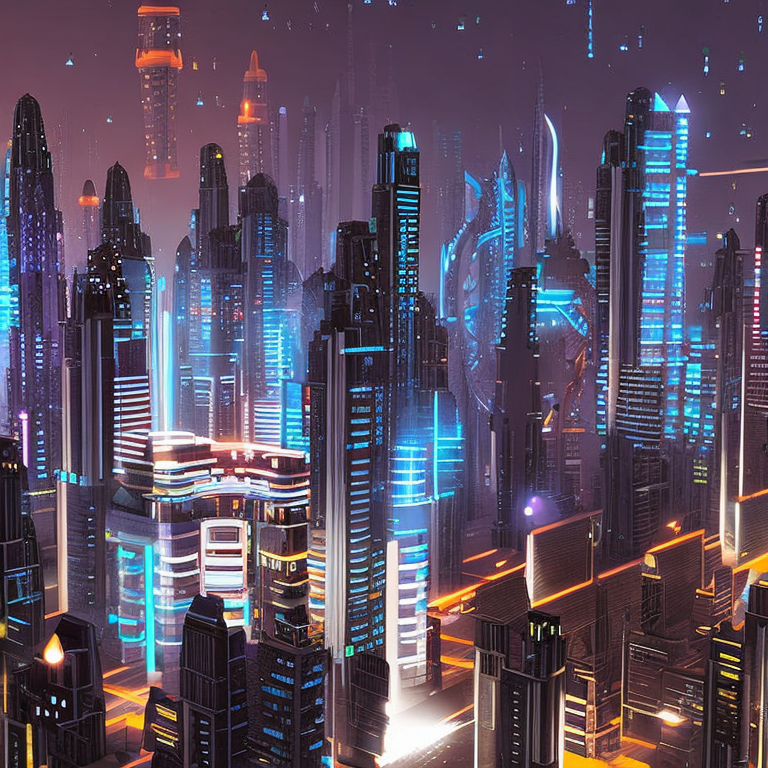

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

# Load the Stable Diffusion model
model_id = "stabilityai/stable-diffusion-2-1"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")  # Move to GPU

# Generate image
prompt = "Futuristic City at Night"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]

# Display image in Colab
image

Save Image to google drive

In [ ]:
output_path = "/content/drive/MyDrive/futuristic_city.png"
image.save(output_path)
print(f"Image saved to {output_path}")

Image saved to /content/drive/MyDrive/futuristic_city.png


## Day 2: Build Core Functionality
- Create a reusable function for image generation.
- Add customization options (steps, guidance scale).
- Test with multiple prompts.
- Implement error handling and save outputs to Google Drive.

1. Reusable Image Generation Function

Function: generate_image encapsulates the Stable Diffusion logic from Day 1, making it reusable.

Parameters:
- prompt: User input text.
- num_inference_steps: Customizable denoising steps (default 50, as per roadmap).
- guidance_scale: Customizable prompt adherence (default 7.5, as per roadmap).
- output_dir: Directory for saving images (set to a dedicated folder in Google Drive).

Error Handling:
- Validates inputs (non-empty prompt, valid step/guidance ranges).
- Catches GPU memory errors (RuntimeError) and general exceptions.

Output:
- Saves images to /content/drive/MyDrive/Text_to_Image_Outputs with a timestamp.
- Logs prompt and settings to the console.
- Returns the image and file path or an error message.
- Global Model: Reuses the pipe variable to avoid reloading the model multiple times, saving time.
- Dependencies: Imports os for directory handling and datetime for timestamps.

In [ ]:


from diffusers import StableDiffusionPipeline
import torch
import os
from datetime import datetime

def enhance_prompt(prompt):
    if not prompt or not isinstance(prompt, str):
        return prompt  # Return unchanged for invalid prompts; handled by generate_image()

    # Convert prompt to lowercase for matching
    base_prompt = prompt.lower().strip()

    # Scene types with associated styles
    scene_styles = {
        "nature": {
            "keywords": ["forest", "mountain", "beach", "jungle", "desert", "lake", "river", "waterfall", "meadow"],
            "style": "hyper-realistic, highly detailed, natural lighting, vibrant colors, serene atmosphere, white balanced"
        },
        "sci-fi": {
            "keywords": ["space", "moon", "planet", "galaxy", "spaceship", "alien", "futuristic", "cyberpunk"],
            "style": "hyper-realistic, highly detailed, cinematic lighting, vibrant galaxy background, futuristic, white balanced"
        },
        "fantasy": {
            "keywords": ["dragon", "castle", "knight", "wizard", "elf", "magic", "medieval", "mythical"],
            "style": "epic fantasy, hyper-realistic, dramatic lighting, intricate details, majestic, white balanced"
        },
        "urban": {
            "keywords": ["city", "skyscraper", "street", "neon", "downtown", "apartment", "traffic"],
            "style": "hyper-realistic, highly detailed, urban lighting, vibrant colors, modern atmosphere, white balanced"
        },
        "underwater": {
            "keywords": ["ocean", "coral", "fish", "submarine", "sea", "reef", "deep sea"],
            "style": "hyper-realistic, highly detailed, aquatic lighting, vibrant colors, serene underwater atmosphere, white balanced"
        },
        "abstract": {
            "keywords": ["abstract", "surreal", "dreamscape", "swirling", "geometric"],
            "style": "hyper-realistic, highly detailed, artistic lighting, vibrant colors, surreal atmosphere, white balanced"
        }
    }

    # Lighting modifiers
    lighting_modifiers = {
        "low light": "soft low lighting, moody atmosphere",
        "bright": "bright lighting, high contrast",
        "dawn": "soft dawn lighting, warm tones",
        "sunset": "warm sunset lighting, golden hues",
        "night": "moonlit night lighting, cool tones",
        "cinematic": "cinematic lighting, dramatic shadows"
    }

    # Default style for unmatched prompts
    default_style = "hyper-realistic, highly detailed, cinematic lighting, vibrant colors, white balanced"

    # Initialize enhancements
    enhancements = []

    # Detect scene type
    selected_style = default_style
    for scene, data in scene_styles.items():
        if any(keyword in base_prompt for keyword in data["keywords"]):
            selected_style = data["style"]
            break

    enhancements.append(selected_style)

    # Detect lighting preferences
    for modifier, style in lighting_modifiers.items():
        if modifier in base_prompt:
            enhancements.append(style)
            # Remove modifier from prompt to avoid redundancy
            base_prompt = base_prompt.replace(modifier, "").strip()

    # Add user-specified style preferences
    if "realistic" in base_prompt:
        enhancements.append("ultra-realistic")
        base_prompt = base_prompt.replace("realistic", "").strip()
    if "vibrant" in base_prompt:
        enhancements.append("highly vibrant colors")
        base_prompt = base_prompt.replace("vibrant", "").strip()
    if "white balanced" in base_prompt:
        enhancements.append("perfectly white balanced")
        base_prompt = base_prompt.replace("white balanced", "").strip()

    # Combine prompt and enhancements
    enhanced_prompt = f"{prompt}, {', '.join(set(enhancements))}"

    return enhanced_prompt

def generate_image(
    prompt,
    num_inference_steps=100,
    guidance_scale=10.0,
    height=768,
    width=768,
    negative_prompt="blurry, low-quality, distorted, pixelated, unrealistic, oversaturated",
    seed=None,
    output_dir="/content/drive/MyDrive/Text_to_Image_Outputs"
):
    """
    Generate an image from a text prompt using Stable Diffusion.
    Args:
        prompt (str): Text description for the image.
        num_inference_steps (int): Number of denoising steps (default: 100).
        guidance_scale (float): Guidance scale for prompt adherence (default: 10.0).
        height (int): Image height in pixels (default: 768).
        width (int): Image width in pixels (default: 768).
        negative_prompt (str): Terms to avoid in the image (default: common artifacts).
        seed (int, optional): Random seed for reproducibility.
        output_dir (str): Directory to save the image.
    Returns:
        tuple: (image, file_path) or (None, error_message) if failed.
    """
    try:
        # Input validation
        if not prompt or not isinstance(prompt, str):
            return None, "Error: Prompt must be a non-empty string."
        if num_inference_steps < 1 or num_inference_steps > 200:
            return None, "Error: num_inference_steps must be between 1 and 200."
        if guidance_scale < 1.0 or guidance_scale > 20.0:
            return None, "Error: guidance_scale must be between 1.0 and 20.0."
        if height < 256 or width < 256 or height % 8 != 0 or width % 8 != 0:
            return None, "Error: height and width must be >= 256 and divisible by 8."
        if negative_prompt and not isinstance(negative_prompt, str):
            return None, "Error: negative_prompt must be a string."
        if seed is not None and not isinstance(seed, int):
            return None, "Error: seed must be an integer."

        # Load model (only once, reuse if already loaded)
        global pipe
        if 'pipe' not in globals():
            model_id = "stabilityai/stable-diffusion-2-1"
            pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
            pipe = pipe.to("cuda")

        # Set seed for reproducibility
        if seed is not None:
            torch.manual_seed(seed)

        # Generate image
        image = pipe(
            prompt=prompt,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            height=height,
            width=width,
            negative_prompt=negative_prompt
        ).images[0]

        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)

        # Save image with descriptive filename
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        safe_prompt = prompt.replace(" ", "_").replace(",", "").lower()[:30]
        file_name = f"{safe_prompt}_{timestamp}.png"
        file_path = os.path.join(output_dir, file_name)
        image.save(file_path)

        # Log settings
        log_message = (
            f"Prompt: {prompt}\n"
            f"Negative Prompt: {negative_prompt}\n"
            f"Steps: {num_inference_steps}\n"
            f"Guidance Scale: {guidance_scale}\n"
            f"Resolution: {height}x{width}\n"
            f"Seed: {seed}\n"
            f"Saved to: {file_path}"
        )
        print(log_message)

        return image, file_path

    except RuntimeError as e:
        return None, f"GPU Memory Error: {str(e)}. Try reducing num_inference_steps or resolution (height/width)."
    except Exception as e:
        return None, f"Error: {str(e)}"

2. Test the Function with Multiple Prompts

- Prompts: Tests 4 prompts (exceeding the roadmap’s 3–5 requirement for robustness).
- Parameters: Uses default values (num_inference_steps=50, guidance_scale=7.5) for consistency with Day 1.

Output:
- Displays each image in Colab (image.show()).
- Saves images to /content/drive/MyDrive/Text_to_Image_Outputs with unique filenames (e.g., image_20250430_123456.png).
- Prints logs for each prompt (prompt, steps, guidance scale, file path).

In [ ]:
# Test enhanced prompts
test_prompts = [
    "Futuristic City at Night",
    "Majestic Snow-Covered Mountain",
    "Steampunk Airship",
    "Underwater Coral Reef",
    "Vintage Car in Desert",
    "Abstract Art",
]

# Run tests with fixed seed for reproducibility
seed = 42
for prompt in test_prompts:
    print(f"\nGenerating enhanced image for: {prompt}")
    # Enhance prompt before generation
    enhanced_prompt = enhance_prompt(prompt)
    print(f"Enhanced Prompt: {enhanced_prompt}")
    image, result = generate_image(
        prompt=enhanced_prompt,
        num_inference_steps=100,
        guidance_scale=10.0,
        height=768,
        width=768,
        negative_prompt="blurry, low-quality, distorted, pixelated, unrealistic, oversaturated",
        seed=seed,
        output_dir="/content/drive/MyDrive/Text_to_Image_Outputs"
    )
    if image:
        image.show()  # Display in Colab
    else:
        print(result)  # Print error message


Generating enhanced image for: Futuristic City at Night
Enhanced Prompt: Futuristic City at Night, hyper-realistic, highly detailed, cinematic lighting, vibrant galaxy background, futuristic, white balanced, moonlit night lighting, cool tones


  0%|          | 0/100 [00:00<?, ?it/s]

Prompt: Futuristic City at Night, hyper-realistic, highly detailed, cinematic lighting, vibrant galaxy background, futuristic, white balanced, moonlit night lighting, cool tones
Negative Prompt: blurry, low-quality, distorted, pixelated, unrealistic, oversaturated
Steps: 100
Guidance Scale: 10.0
Resolution: 768x768
Seed: 42
Saved to: /content/drive/MyDrive/Text_to_Image_Outputs/futuristic_city_at_night_hyper_20250504_003304.png

Generating enhanced image for: Majestic Snow-Covered Mountain
Enhanced Prompt: Majestic Snow-Covered Mountain, hyper-realistic, highly detailed, natural lighting, vibrant colors, serene atmosphere, white balanced


  0%|          | 0/100 [00:00<?, ?it/s]

Prompt: Majestic Snow-Covered Mountain, hyper-realistic, highly detailed, natural lighting, vibrant colors, serene atmosphere, white balanced
Negative Prompt: blurry, low-quality, distorted, pixelated, unrealistic, oversaturated
Steps: 100
Guidance Scale: 10.0
Resolution: 768x768
Seed: 42
Saved to: /content/drive/MyDrive/Text_to_Image_Outputs/majestic_snow-covered_mountain_20250504_003339.png

Generating enhanced image for: Steampunk Airship
Enhanced Prompt: Steampunk Airship, hyper-realistic, highly detailed, cinematic lighting, vibrant colors, white balanced


  0%|          | 0/100 [00:00<?, ?it/s]

Prompt: Steampunk Airship, hyper-realistic, highly detailed, cinematic lighting, vibrant colors, white balanced
Negative Prompt: blurry, low-quality, distorted, pixelated, unrealistic, oversaturated
Steps: 100
Guidance Scale: 10.0
Resolution: 768x768
Seed: 42
Saved to: /content/drive/MyDrive/Text_to_Image_Outputs/steampunk_airship_hyper-realis_20250504_003414.png

Generating enhanced image for: Underwater Coral Reef
Enhanced Prompt: Underwater Coral Reef, hyper-realistic, highly detailed, aquatic lighting, vibrant colors, serene underwater atmosphere, white balanced


  0%|          | 0/100 [00:00<?, ?it/s]

Prompt: Underwater Coral Reef, hyper-realistic, highly detailed, aquatic lighting, vibrant colors, serene underwater atmosphere, white balanced
Negative Prompt: blurry, low-quality, distorted, pixelated, unrealistic, oversaturated
Steps: 100
Guidance Scale: 10.0
Resolution: 768x768
Seed: 42
Saved to: /content/drive/MyDrive/Text_to_Image_Outputs/underwater_coral_reef_hyper-re_20250504_003448.png

Generating enhanced image for: Vintage Car in Desert
Enhanced Prompt: Vintage Car in Desert, hyper-realistic, highly detailed, natural lighting, vibrant colors, serene atmosphere, white balanced


  0%|          | 0/100 [00:00<?, ?it/s]

Prompt: Vintage Car in Desert, hyper-realistic, highly detailed, natural lighting, vibrant colors, serene atmosphere, white balanced
Negative Prompt: blurry, low-quality, distorted, pixelated, unrealistic, oversaturated
Steps: 100
Guidance Scale: 10.0
Resolution: 768x768
Seed: 42
Saved to: /content/drive/MyDrive/Text_to_Image_Outputs/vintage_car_in_desert_hyper-re_20250504_003523.png

Generating enhanced image for: Abstract Art
Enhanced Prompt: Abstract Art, hyper-realistic, highly detailed, artistic lighting, vibrant colors, surreal atmosphere, white balanced


  0%|          | 0/100 [00:00<?, ?it/s]

Prompt: Abstract Art, hyper-realistic, highly detailed, artistic lighting, vibrant colors, surreal atmosphere, white balanced
Negative Prompt: blurry, low-quality, distorted, pixelated, unrealistic, oversaturated
Steps: 100
Guidance Scale: 10.0
Resolution: 768x768
Seed: 42
Saved to: /content/drive/MyDrive/Text_to_Image_Outputs/abstract_art_hyper-realistic_h_20250504_003558.png


3. Test Customization Options

- Tests a new prompt with custom parameters (num_inference_steps=75, guidance_scale=10.0).
- Verifies the function’s ability to handle different settings, as required by the roadmap.
- Displays the image and logs custom settings or errors.
- Saves the image to the same output directory.

In [ ]:
# Test customization with enhanced prompt
custom_prompt = "a serene beach at dawn"
custom_steps = 75
custom_guidance = 10.0
seed = 42

print(f"\nTesting customization: {custom_prompt}")
# Enhance prompt before generation
enhanced_prompt = enhance_prompt(custom_prompt)
print(f"Enhanced Prompt: {enhanced_prompt}")
image, result = generate_image(
    prompt=enhanced_prompt,
    num_inference_steps=custom_steps,
    guidance_scale=custom_guidance,
    height=768,
    width=768,
    negative_prompt="blurry, low-quality, distorted, pixelated, unrealistic, oversaturated",
    seed=seed,
    output_dir="/content/drive/MyDrive/Text_to_Image_Outputs"
)
if image:
    image.show()
    print(f"Custom settings: Steps={custom_steps}, Guidance={custom_guidance}, Seed={seed}")
else:
    print(result)


Testing customization: a serene beach at dawn
Enhanced Prompt: a serene beach at dawn, hyper-realistic, highly detailed, natural lighting, vibrant colors, serene atmosphere, white balanced, soft dawn lighting, warm tones


  0%|          | 0/75 [00:00<?, ?it/s]

Prompt: a serene beach at dawn, hyper-realistic, highly detailed, natural lighting, vibrant colors, serene atmosphere, white balanced, soft dawn lighting, warm tones
Negative Prompt: blurry, low-quality, distorted, pixelated, unrealistic, oversaturated
Steps: 75
Guidance Scale: 10.0
Resolution: 768x768
Seed: 42
Saved to: /content/drive/MyDrive/Text_to_Image_Outputs/a_serene_beach_at_dawn_hyper-r_20250503_141543.png
Custom settings: Steps=75, Guidance=10.0, Seed=42


4. Test Error Handling

- Tests three error cases: empty prompt, invalid num_inference_steps, and invalid guidance_scale.
- Verifies the function’s error handling, as required by the roadmap.
- Prints error messages without crashing.

In [ ]:
# Test error handling
error_tests = [
    {"prompt": "", "steps": 50, "guidance": 7.5},  # Empty prompt
    {"prompt": "test", "steps": 150, "guidance": 7.5},  # Invalid steps
    {"prompt": "test", "steps": 50, "guidance": 25.0},  # Invalid guidance
]

for test in error_tests:
    print(f"\nTesting error case: {test}")
    image, result = generate_image(
        prompt=test["prompt"],
        num_inference_steps=test["steps"],
        guidance_scale=test["guidance"],
        output_dir="/content/drive/MyDrive/Text_to_Image_Outputs"
    )
    print(result)


Testing error case: {'prompt': '', 'steps': 50, 'guidance': 7.5}
Error: Prompt must be a non-empty string.

Testing error case: {'prompt': 'test', 'steps': 150, 'guidance': 7.5}


  0%|          | 0/150 [00:00<?, ?it/s]

Prompt: test
Negative Prompt: blurry, low-quality, distorted, pixelated, unrealistic, oversaturated
Steps: 150
Guidance Scale: 7.5
Resolution: 768x768
Seed: None
Saved to: /content/drive/MyDrive/Text_to_Image_Outputs/test_20250502_113514.png
/content/drive/MyDrive/Text_to_Image_Outputs/test_20250502_113514.png

Testing error case: {'prompt': 'test', 'steps': 50, 'guidance': 25.0}
Error: guidance_scale must be between 1.0 and 20.0.


## Day 3: Prototype Streamlit Interface
- Build a Streamlit app with text input, slider for num_inference_steps, and generate button.
- Test locally in Colab using ngrok.
- Use enhanced generate_image() function from Day 2.5.

In [ ]:
import streamlit as st
from PIL import Image
import os
from google.colab import drive

# Mount Google Drive
try:
    drive.mount('/content/drive')
except Exception as e:
    st.error(f"Failed to mount Google Drive: {str(e)}")
    raise

# Assume enhance_prompt() and generate_image() are defined (from Day 2.5)
def main():
    st.title("Text-to-Image Generator")
    st.write("Enter a prompt and customize settings to generate an image using Stable Diffusion.")

    # Text input for prompt
    prompt = st.text_input("Prompt", value="a serene beach at dawn")

    # Slider for num_inference_steps
    num_inference_steps = st.slider("Number of Inference Steps", min_value=25, max_value=100, value=50, step=5)

    # Slider for guidance_scale
    guidance_scale = st.slider("Guidance Scale", min_value=1.0, max_value=20.0, value=10.0, step=0.5)

    # Text input for negative prompt
    negative_prompt = st.text_input("Negative Prompt", value="blurry, low-quality, distorted, pixelated, unrealistic, oversaturated")

    # Dropdown for resolution
    resolution = st.selectbox("Resolution", ["512x512", "768x768"], index=1)
    height, width = map(int, resolution.split('x'))

    # Button to generate image
    if st.button("Generate Image"):
        if not prompt:
            st.error("Please enter a prompt.")
            return

        with st.spinner("Generating image..."):
            # Enhance prompt
            enhanced_prompt = enhance_prompt(prompt)
            st.write(f"Enhanced Prompt: {enhanced_prompt}")

            # Generate image with user-specified parameters
            image, result = generate_image(
                prompt=enhanced_prompt,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                height=height,
                width=width,
                negative_prompt=negative_prompt,
                seed=42,
                output_dir="/content/drive/MyDrive/Text_to_Image_Outputs"
            )

            if image:
                st.image(image, caption="Generated Image", use_container_width=True)
                st.success(f"Image saved to: {result}")
            else:
                st.error(result)

if __name__ == "__main__":
    main()

2025-05-03 15:19:23.651 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-03 15:19:23.652 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-03 15:19:23.653 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-03 15:19:23.654 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-03 15:19:23.655 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-03 15:19:23.655 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-03 15:19:23.657 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-03 15:19:23.658 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Ngrok Testing (Second Cell)
# Install pyngrok for tunneling
!pip install pyngrok

# Save Streamlit app to a file
with open("app.py", "w") as f:
    f.write('''
import streamlit as st
from PIL import Image
import os
from diffusers import StableDiffusionPipeline
import torch
from datetime import datetime

def enhance_prompt(prompt):
    if not prompt or not isinstance(prompt, str):
        return prompt

    base_prompt = prompt.lower().strip()

    scene_styles = {
        "nature": {
            "keywords": ["forest", "mountain", "beach", "jungle", "desert", "lake", "river", "waterfall", "meadow"],
            "style": "hyper-realistic, highly detailed, natural lighting, vibrant colors, serene atmosphere, white balanced"
        },
        "sci-fi": {
            "keywords": ["space", "moon", "planet", "galaxy", "spaceship", "alien", "futuristic", "cyberpunk"],
            "style": "hyper-realistic, highly detailed, cinematic lighting, vibrant galaxy background, futuristic, white balanced"
        },
        "fantasy": {
            "keywords": ["dragon", "castle", "knight", "wizard", "elf", "magic", "medieval", "mythical"],
            "style": "epic fantasy, hyper-realistic, dramatic lighting, intricate details, majestic, white balanced"
        },
        "urban": {
            "keywords": ["city", "skyscraper", "street", "neon", "downtown", "apartment", "traffic"],
            "style": "hyper-realistic, highly detailed, urban lighting, vibrant colors, modern atmosphere, white balanced"
        },
        "underwater": {
            "keywords": ["ocean", "coral", "fish", "submarine", "sea", "reef", "deep sea"],
            "style": "hyper-realistic, highly detailed, aquatic lighting, vibrant colors, serene underwater atmosphere, white balanced"
        },
        "abstract": {
            "keywords": ["abstract", "surreal", "dreamscape", "swirling", "geometric"],
            "style": "hyper-realistic, highly detailed, artistic lighting, vibrant colors, surreal atmosphere, white balanced"
        }
    }

    lighting_modifiers = {
        "low light": "soft low lighting, moody atmosphere",
        "bright": "bright lighting, high contrast",
        "dawn": "soft dawn lighting, warm tones",
        "sunset": "warm sunset lighting, golden hues",
        "night": "moonlit night lighting, cool tones",
        "cinematic": "cinematic lighting, dramatic shadows"
    }

    default_style = "hyper-realistic, highly detailed, cinematic lighting, vibrant colors, white balanced"

    enhancements = []

    selected_style = default_style
    for scene, data in scene_styles.items():
        if any(keyword in base_prompt for keyword in data["keywords"]):
            selected_style = data["style"]
            break

    enhancements.append(selected_style)

    for modifier, style in lighting_modifiers.items():
        if modifier in base_prompt:
            enhancements.append(style)
            base_prompt = base_prompt.replace(modifier, "").strip()

    if "realistic" in base_prompt:
        enhancements.append("ultra-realistic")
        base_prompt = base_prompt.replace("realistic", "").strip()
    if "vibrant" in base_prompt:
        enhancements.append("highly vibrant colors")
        base_prompt = base_prompt.replace("vibrant", "").strip()
    if "white balanced" in base_prompt:
        enhancements.append("perfectly white balanced")
        base_prompt = base_prompt.replace("white balanced", "").strip()

    enhanced_prompt = f"{prompt}, {', '.join(set(enhancements))}"

    return enhanced_prompt

def generate_image(
    prompt,
    num_inference_steps=100,
    guidance_scale=10.0,
    height=768,
    width=768,
    negative_prompt="blurry, low-quality, distorted, pixelated, unrealistic, oversaturated",
    seed=None,
    output_dir="/content/drive/MyDrive/Text_to_Image_Outputs"
):
    try:
        if not prompt or not isinstance(prompt, str):
            return None, "Error: Prompt must be a non-empty string."
        if num_inference_steps < 1 or num_inference_steps > 200:
            return None, "Error: num_inference_steps must be between 1 and 200."
        if guidance_scale < 1.0 or guidance_scale > 20.0:
            return None, "Error: guidance_scale must be between 1.0 and 20.0."
        if height < 256 or width < 256 or height % 8 != 0 or width % 8 != 0:
            return None, "Error: height and width must be >= 256 and divisible by 8."
        if negative_prompt and not isinstance(negative_prompt, str):
            return None, "Error: negative_prompt must be a string."
        if seed is not None and not isinstance(seed, int):
            return None, "Error: seed must be an integer."

        global pipe
        if 'pipe' not in globals():
            model_id = "stabilityai/stable-diffusion-2-1"
            pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
            pipe = pipe.to("cuda")

        if seed is not None:
            torch.manual_seed(seed)

        image = pipe(
            prompt=prompt,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            height=height,
            width=width,
            negative_prompt=negative_prompt
        ).images[0]

        os.makedirs(output_dir, exist_ok=True)

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        safe_prompt = prompt.replace(" ", "_").replace(",", "").lower()[:30]
        file_name = f"{safe_prompt}_{timestamp}.png"
        file_path = os.path.join(output_dir, file_name)

        try:
            image.save(file_path)
            if not os.path.exists(file_path):
                return None, f"Error: Failed to save image to {file_path}. File does not exist."
        except Exception as e:
            return None, f"Error: Failed to save image to {file_path}: {str(e)}"

        log_message = (
            f"Prompt: {prompt}\\n"
            f"Negative Prompt: {negative_prompt}\\n"
            f"Steps: {num_inference_steps}\\n"
            f"Guidance Scale: {guidance_scale}\\n"
            f"Resolution: {height}x{width}\\n"
            f"Seed: {seed}\\n"
            f"Saved to: {file_path}"
        )
        print(log_message)

        return image, file_path

    except RuntimeError as e:
        return None, f"GPU Memory Error: {str(e)}. Try reducing num_inference_steps or resolution (height/width)."
    except Exception as e:
        return None, f"Error: {str(e)}"

def main():
    st.title("Text-to-Image Generator")
    st.write("Enter a prompt and customize settings to generate an image using Stable Diffusion.")
    prompt = st.text_input("Prompt", value="a serene beach at dawn")
    num_inference_steps = st.slider("Number of Inference Steps", min_value=25, max_value=100, value=50, step=5)
    guidance_scale = st.slider("Guidance Scale", min_value=1.0, max_value=20.0, value=10.0, step=0.5)
    negative_prompt = st.text_input("Negative Prompt", value="blurry, low-quality, distorted, pixelated, unrealistic, oversaturated")
    resolution = st.selectbox("Resolution", ["512x512", "768x768"], index=1)
    height, width = map(int, resolution.split('x'))
    if st.button("Generate Image"):
        if not prompt:
            st.error("Please enter a prompt.")
            return
        with st.spinner("Generating image..."):
            enhanced_prompt = enhance_prompt(prompt)
            st.write(f"Enhanced Prompt: {enhanced_prompt}")
            image, result = generate_image(
                prompt=enhanced_prompt,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                height=height,
                width=width,
                negative_prompt=negative_prompt,
                seed=42,
                output_dir="/content/drive/MyDrive/Text_to_Image_Outputs"
            )
            if image:
                st.image(image, caption="Generated Image", use_container_width=True)
                st.success(f"Image saved to: {result}")
            else:
                st.error(result)
if __name__ == "__main__":
    main()
''')

# Run Streamlit and ngrok with clean shutdown
import subprocess
import signal
import os
from pyngrok import ngrok

# Set ngrok authtoken
!ngrok authtoken YOUR_NGROK_AUTHTOKEN

# Start ngrok tunnel
public_url = ngrok.connect(8501)
print(f"Streamlit app running at: {public_url}")

# Start Streamlit server
streamlit_cmd = ["streamlit", "run", "app.py", "--server.port", "8501", "--server.fileWatcherType", "none"]
streamlit_proc = subprocess.Popen(streamlit_cmd)

# Handle shutdown
def signal_handler(sig, frame):
    print("Shutting down Streamlit and ngrok...")
    streamlit_proc.terminate()
    ngrok.kill()
    print("Shutdown complete.")
    os._exit(0)

signal.signal(signal.SIGINT, signal_handler)

# Keep the cell running
try:
    streamlit_proc.wait()
except KeyboardInterrupt:
    signal_handler(None, None)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Streamlit app running at: NgrokTunnel: "https://52c8-35-247-165-178.ngrok-free.app" -> "http://localhost:8501"
